In [1]:
## this is JP's experimental workbook v2.
## Please do not modify this file - you are welcome to save a copy
## for yourself
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
import os, sys, keras, copy
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf

Using TensorFlow backend.


In [3]:
from graphTools import *
from layerTools import *

In [4]:

# Read in graphs
graph_files = glob.glob('qm9graph/*.csv')[0:10000]
mygraphs = [readgraph(fname) for fname in graph_files]
headers_onehot_dict, matrices_onehot_dict, mygraphs_standardized = standardize_graphs(mygraphs, max_size=29,skipZero=False)
headers_padded = np.array([i['header'] for i in mygraphs_standardized])
matrices_padded = np.array([i['matrix'] for i in mygraphs_standardized])
connectivities_padded = np.array([i['connectivity'] for i in mygraphs_standardized])
origHeaders_padded = np.array([i['origHeader'] for i in mygraphs_standardized])
origMatrices_padded = np.array([i['origMatrix'] for i in mygraphs_standardized])
print headers_padded.shape
print matrices_padded.shape
print connectivities_padded.shape

Header One-Hot Map: {0.0: array([1., 0., 0., 0., 0., 0.]), 1.0: array([0., 1., 0., 0., 0., 0.]), 6.0: array([0., 0., 1., 0., 0., 0.]), 7.0: array([0., 0., 0., 1., 0., 0.]), 8.0: array([0., 0., 0., 0., 1., 0.]), 9.0: array([0., 0., 0., 0., 0., 1.])}
Bond One-Hot Map: {0.0: array([1., 0., 0., 0.]), 1.0: array([0., 1., 0., 0.]), 2.0: array([0., 0., 1., 0.]), 3.0: array([0., 0., 0., 1.])}
Graph Size: 29
Number of dropped graphs: 0
(10000, 29, 6)
(10000, 29, 29, 4)
(10000, 29, 29)


In [5]:
gumbel_softmax_mask = lambda x: gumbel_softmax(logits=x,temperature=0.05)

In [6]:
num_input =5 
latent_dim = 50
noise_input = np.random.randn(num_input,latent_dim)
num_nodes = 29

In [7]:
bond_types = 4
minimal_mats = None
for m in matrices_padded:
    minimal_m = minimalize_BO_matrix(m,num_nodes)
    if minimal_mats is None:
        minimal_mats = minimal_m.reshape((1,(num_nodes*num_nodes - num_nodes)/2,bond_types))
        print(minimal_mats.shape)
    else:    
        minimal_mats = np.concatenate([minimal_mats,minimal_m.reshape((1,(num_nodes*num_nodes - num_nodes)/2,bond_types))],
                                      axis=0)

(1, 406, 4)


In [8]:
minimal_mats.shape

(10000, 406, 4)

In [9]:
def get_bonding_mask(nodeslist, bond_types=4):
    print(nodeslist.shape)
    populated_nodes  = np.diag(np.sum(nodeslist,axis=2))
    print(populated_nodes.shape)
    all_bonds = np.ones((len(nodeslist),len(nodeslist))) - np.identity(len(nodeslist))
    vector_mask = generate_vector(np.matmul(populated_nodes,all_bonds),len(nodeslist))
    vector_mask=np.repeat(np.reshape(vector_mask,(len(vector_mask),2)),bond_types,axis=1)
    return(vector_mask)
    

In [10]:
from keras.layers import Input, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

def deterministic_edge_reconstructor(num_nodes=29,atom_types=6,bond_types=4):
        num_edges = (num_nodes*num_nodes -num_nodes)/2

        inputBOLayer = Input(shape=(num_nodes,atom_types,))
        first_dense = keras.layers.Dense(50, name="first_BO_dense")(inputBOLayer)
        first_leaky = LeakyReLU(alpha=0.1,name="first_BO_LReLU")(first_dense)
        first_dropout = Dropout(rate=0.15,name="first_drop")(first_leaky)

        second_dense = keras.layers.Dense(50, name="second_BO_dense")(first_dropout)
        second_leaky = LeakyReLU(alpha=0.1,name="second_BO_LReLU")(second_dense)
        second_dropout = Dropout(rate=0.15,name="second_drop")(second_leaky)

        
        third_dense = keras.layers.Dense(num_edges*(bond_types)/num_nodes,name="third_BO_dense")(second_dropout)
        third_leaky = LeakyReLU(alpha=0.1,name="third_gen_LReLU")(third_dense)
        bo_reshape = keras.layers.Reshape((num_edges,bond_types),name="reshape")(third_leaky)
        #bo_legalize = keras.layers.Multiply(name='mask apply')[bo_reshape,bo_mask]

        bo_logits = keras.layers.Dense(bond_types, activation='linear',name="linear_logits")(bo_reshape)
        bo_samples = keras.layers.Lambda(gumbel_softmax_mask,name="gumbel_softmax")(bo_logits)

        bo_model = keras.models.Model(inputs=[inputBOLayer],outputs=[bo_samples])
        return(bo_model)

In [11]:
minimal_mats.shape

(10000, 406, 4)

In [12]:
np.random.seed(3)
# get random partition
msk = np.random.rand(np.shape(headers_padded)[0]) < 0.75
# test and train split
train_matrices_minimal = minimal_mats[msk,:,:]
train_headers_padded = headers_padded[msk,:]
train_connectivities_padded = connectivities_padded[msk,:,:]
test_matrices_minimal_mats = minimal_mats[~msk,:,:]
test_headers_padded = headers_padded[~msk,:]
test_connectivities_padded = connectivities_padded[~msk,:,:]

In [13]:
## def zero-ize bond orders

In [14]:
headers_padded.shape

(10000, 29, 6)

In [15]:
test_matrices_minimal_mats.shape

(2476, 406, 4)

In [16]:
bo_model_n = deterministic_edge_reconstructor()
bo_model_n.compile(optimizer='adam',loss='categorical_crossentropy',
                 metrics=['categorical_accuracy','categorical_crossentropy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
bo_model_n.predict(train_headers_padded).shape

(7524, 406, 4)

In [18]:
tp = bo_model_n.predict(train_headers_padded)

In [19]:
tp[0]

array([[9.6716879e-12, 2.4792887e-05, 5.4757500e-18, 9.9997520e-01],
       [6.2447319e-36, 1.0000000e+00, 0.0000000e+00, 5.6525600e-16],
       [1.0000000e+00, 1.3356673e-18, 9.4643591e-09, 1.1519420e-22],
       ...,
       [3.9503015e-11, 4.1038454e-01, 3.9630770e-08, 5.8961535e-01],
       [5.8466118e-19, 7.4052834e-20, 9.9999905e-01, 8.9683272e-07],
       [1.0000000e+00, 2.0152907e-38, 2.2939156e-17, 2.1085932e-38]],
      dtype=float32)

In [30]:
headers_padded[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

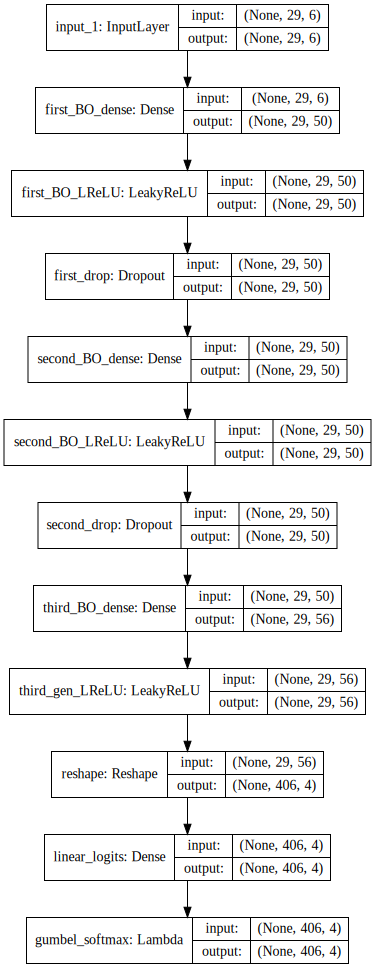

In [21]:
SVG(model_to_dot(bo_model_n,show_shapes=True).create(prog='dot', format='svg'))


In [22]:
res = bo_model_n.fit(train_headers_padded,train_matrices_minimal,epochs=100, batch_size=1000,
                            validation_split=0.1,
                            verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 6771 samples, validate on 753 samples
Epoch 1/100
6771/6771 [==============================] - 1s 193us/step - loss: 10.9605 - categorical_accuracy: 0.2389 - categorical_crossentropy: 10.9605 - val_loss: 10.7513 - val_categorical_accuracy: 0.2492 - val_categorical_crossentropy: 10.7513
Epoch 2/100
6771/6771 [==============================] - 1s 113us/step - loss: 10.6914 - categorical_accuracy: 0.2529 - categorical_crossentropy: 10.6915 - val_loss: 10.5273 - val_categorical_accuracy: 0.2617 - val_categorical_crossentropy: 10.5273
Epoch 3/100
6771/6771 [==============================] - 1s 111us/step - loss: 10.4880 - categorical_accuracy: 0.2637 - categorical_crossentropy: 10.4881 - val_loss: 10.3633 - val_categorical_accuracy: 0.2704 - val_categorical_crossentropy: 10.3634
Epoch 4/100
6771/6771 [==============================] - 1s 111us/step - loss: 10.3040 - categorical_accuracy: 0.2738 - categorical_crossentropy: 10.3041 - va

Epoch 33/100
6771/6771 [==============================] - 1s 111us/step - loss: 0.7647 - categorical_accuracy: 0.9521 - categorical_crossentropy: 0.7647 - val_loss: 0.7617 - val_categorical_accuracy: 0.9524 - val_categorical_crossentropy: 0.7617
Epoch 34/100
6771/6771 [==============================] - 1s 114us/step - loss: 0.7634 - categorical_accuracy: 0.9522 - categorical_crossentropy: 0.7634 - val_loss: 0.7625 - val_categorical_accuracy: 0.9524 - val_categorical_crossentropy: 0.7625
Epoch 35/100
6771/6771 [==============================] - 1s 113us/step - loss: 0.7623 - categorical_accuracy: 0.9523 - categorical_crossentropy: 0.7623 - val_loss: 0.7608 - val_categorical_accuracy: 0.9525 - val_categorical_crossentropy: 0.7608
Epoch 36/100
6771/6771 [==============================] - 1s 109us/step - loss: 0.7613 - categorical_accuracy: 0.9524 - categorical_crossentropy: 0.7613 - val_loss: 0.7599 - val_categorical_accuracy: 0.9526 - val_categorical_crossentropy: 0.7599
Epoch 37/100
677

6771/6771 [==============================] - 1s 106us/step - loss: 0.7517 - categorical_accuracy: 0.9533 - categorical_crossentropy: 0.7517 - val_loss: 0.7532 - val_categorical_accuracy: 0.9532 - val_categorical_crossentropy: 0.7532
Epoch 67/100
6771/6771 [==============================] - 1s 104us/step - loss: 0.7516 - categorical_accuracy: 0.9533 - categorical_crossentropy: 0.7516 - val_loss: 0.7531 - val_categorical_accuracy: 0.9532 - val_categorical_crossentropy: 0.7531
Epoch 68/100
6771/6771 [==============================] - 1s 110us/step - loss: 0.7515 - categorical_accuracy: 0.9533 - categorical_crossentropy: 0.7515 - val_loss: 0.7536 - val_categorical_accuracy: 0.9532 - val_categorical_crossentropy: 0.7536
Epoch 69/100
6771/6771 [==============================] - 1s 110us/step - loss: 0.7515 - categorical_accuracy: 0.9533 - categorical_crossentropy: 0.7515 - val_loss: 0.7527 - val_categorical_accuracy: 0.9533 - val_categorical_crossentropy: 0.7527
Epoch 70/100
6771/6771 [=====

6771/6771 [==============================] - 1s 105us/step - loss: 0.7500 - categorical_accuracy: 0.9534 - categorical_crossentropy: 0.7500 - val_loss: 0.7521 - val_categorical_accuracy: 0.9533 - val_categorical_crossentropy: 0.7521
Epoch 100/100
6771/6771 [==============================] - 1s 107us/step - loss: 0.7500 - categorical_accuracy: 0.9534 - categorical_crossentropy: 0.7500 - val_loss: 0.7520 - val_categorical_accuracy: 0.9533 - val_categorical_crossentropy: 0.7520


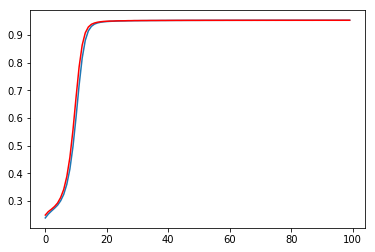

In [25]:
import matplotlib.pyplot as plt
plt.plot(res.history['categorical_accuracy'])
plt.plot(res.history['val_categorical_accuracy'],'r')
plt.show()

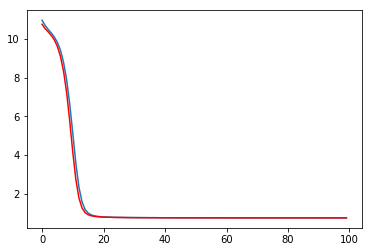

In [24]:
import matplotlib.pyplot as plt
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'],'r')
plt.show()

In [26]:
# test predictions
test_predictions = bo_model_n.predict(test_headers_padded)
test_res = bo_model_n.evaluate(test_headers_padded,test_matrices_minimal_mats)
print(test_res)

test_class_pred = test_predictions.argmax(axis=2)
test_erroors = test_matrices_minimal_mats.argmax(axis=2)

#err_rate = 100*np.sum(np.sum(test_errors))/float(test_class_act.shape[0]*test_class_act.shape[1])
#print('test error rate is ' + str(err_rate))


2476/2476 [==============================] - 0s 81us/step
[0.7455040440805895, 0.9537242208043285, 0.7455043074387533]


In [27]:
test_predictions.argmax(axis=2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
test_predictions[0]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [29]:
test_class_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_matrices_minimal_mats[0].argmax(axis=1)

In [ ]:
test_class_pred = test_predictions.argmax(axis=2)

In [ ]:
test_class_pred.shape

In [ ]:
test_predictions[0]

In [ ]:
test_predictions

In [ ]:
zta = (0.2)*np.ones((test_predictions.shape[0],test_predictions.shape[1],1))
print(zta.shape)

In [ ]:
test_augment = np.concatenate([np.zeros((test_predictions.shape[0],test_predictions.shape[1],1)),test_predictions],axis=2)
test_class= test_augment.argmax(axis=2)

In [ ]:
test_augment[0]

In [ ]:
test_augment[0].argmax(axis=1)

In [ ]:
len(msk)

In [ ]:
mm = minimal_mats[0:1].squeeze()
bms = mm.argmax(axis=1)
print(bms)

In [ ]:
pos.argmax(axis=2)

In [ ]:
headers_padded[0:1]

In [ ]:
gumbel_softmax_mask = lambda x: gumbel_softmax(logits=x,temperature=0.05)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
## first step is to generate a node label vector 
def bo_gen(latent_dim,num_nodes,atom_types):
    inputLayer = keras.layers.Input(shape=(latent_dim,))
    first_dense = keras.layers.Dense(128, name="first_gen_dense")(inputLayer)
    first_leaky = LeakyReLU(alpha=0.3,name="first_gen_LReLU")(first_dense)
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    second_dense = keras.layers.Dense(128,name="second_gen_dense")(first_drop)
    second_leaky = LeakyReLU(alpha=0.3,name="second_gen_LReLU")(second_dense)
    second_drop = Dropout(rate = 0.15,name="second_gen_dropout")(second_leaky)
    third_dense = keras.layers.Dense(num_nodes*64*atom_types, name="third_gen_dense")(second_drop)
    third_leaky = LeakyReLU(alpha=0.3,name="third_gen_LReLU")(third_dense) 
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    node_reshape = keras.layers.Reshape((num_nodes,64*atom_types),name="reshape")(third_leaky)
    #node_probs = keras.layers.Dense(atom_types, activation='softmax')(node_reshape)
    node_logits = keras.layers.Dense(atom_types, activation='linear',name="linear_logits")(node_reshape)
    node_samples = keras.layers.Lambda(gumbel_softmax_mask,name="gumbel_softmax")(node_logits)
    node_trim = keras.layers.Lambda(zero_atom_trimmer,name="trim_samples")(node_samples)
    node_model = keras.models.Model(inputs=[inputLayer],outputs=[node_trim])
    return(node_model)


In [31]:
29*29

841

In [ ]:
minimal_mats.shape

In [ ]:
"".join([mapping_dict[float(i)] for i in fk])

In [ ]:
"".join([mapping_dict[float(i)] for i in rl])

In [ ]:
wrd.count('C')

In [ ]:
wrd.count('H')

In [ ]:
headers_onehot_dict

In [ ]:
SVG(model_to_dot(combined,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
combined.summary()

In [ ]:
combined.predict(noise_input)

In [ ]:
num_input  = 100

In [ ]:
# generate synthetic nodes
gen_noise = np.random.randn(num_input,latent_dim)
synthetic_nodes = gen_mods.predict(gen_noise)
print(synthetic_nodes.shape)

In [ ]:
real_nodes = headers_padded[0:100,:,:]
print(real_nodes.shape)
batch = 200

In [ ]:
x_combined_batch = np.concatenate((real_nodes, synthetic_nodes))
y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

In [ ]:
y_combined_batch.shape

In [ ]:
## train discriminator
disc_hist = disc_model.fit(x_combined_batch, y_combined_batch,epochs=4, verbose=1)

In [ ]:
disc_hist = disc_model.train_on_batch(x_combined_batch, y_combined_batch)

In [ ]:
disc_hist

In [ ]:
# create a batch of synthetic noises
noise = np.random.normal(0, 1, (batch, latent_dim))
y_mislabled = np.ones((batch, 1))

In [ ]:
gen_hist = combined.fit(noise, y_mislabled,epochs=500, batch_size=10, verbose=1)

In [ ]:
disc_model.predict(synthetic_nodes[0:10,:,:])

In [ ]:
synthetic_nodes[0,:,:].argmax(axis=1)

In [ ]:
headers_padded[0,:,:].argmax(axis=1)

In [ ]:
batch = 120


print(data_length)


In [ ]:
print(float(data_length)/batch)

In [ ]:
print(num_batches)

In [ ]:
noise_input